## They don't keep me here cause I'm gorgeous they keep me here cause I'm smart

#### World Population Data

<AxesSubplot:xlabel='Year'>

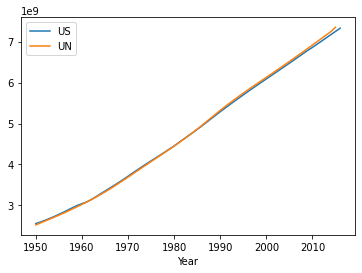

In [266]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

site = "https://en.wikipedia.org/wiki/Estimates_of_historical_world_population"
# parse all tables from Wikipedia page
# use M as decimal point to allow for numbers expressed in millions to be treated as values
tables = pd.read_html(site, header=0, index_col=0, decimal='M')

# grab table with population data from 1950 - 2016
table = tables[2]

# parse growth rate info
growth = pd.read_csv("data/growth_rate.csv", header=0, index_col=0)

# rename and remove unnecessary columns
table.columns = ["US", "PRB", "UN", "Maddison", "HYDE", "Tanton", "Biraben", "M&J", "Thomlinson", "Durand", "Clark"]
table.drop(columns=["PRB", "Maddison", "HYDE", "Tanton", "Biraben", "M&J", "Thomlinson", "Durand", "Clark"], inplace=True)

# parse birth rate and death rate data
BrDrGraph = pd.read_csv ('data/br_dr_stats.csv')

# plot population growth from 1950 to 2016
table.plot()

#### Projecting Population

Proportional growth using projected growth and death rates

7.567556146328109
10.410889393694553


/var/folders/w0/yrpqk6290831h42hbdj_l6v00000gn/T/ipykernel_73853/899610297.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[i + 1] = x[i] + 1


<AxesSubplot:>

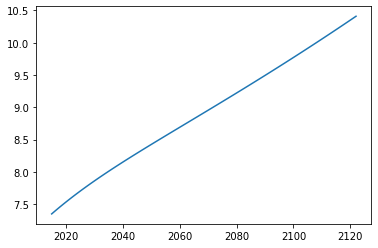

In [282]:
un = table.UN / 1e9
us = table.US / 1e9

t0 = un.index[0]
t1 = un.index[-2]
time = t1 - t0

p0 = un[t0]
p1 = un[t1]

x = BrDrGraph["Year"]
yBR = BrDrGraph["BR"]
yDR = BrDrGraph["DR"]

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k * (x - x0))) + b
    return (y)

p0BR = [max(yBR), np.median(x), 1, min(yBR)]
p0DR = [max(yDR), np.median(x), 1, min(yDR)]

poptBR, pcovBR = curve_fit(sigmoid, x, yBR, p0BR, method="dogbox")
poptDR, pcovDR = curve_fit(sigmoid, x, yDR, p0DR, method="dogbox")

i = 71
while x[i] != 2122: 
    x[i + 1] = x[i] + 1
    i = i + 1
    
br = sigmoid(x, *poptBR)
dr = sigmoid(x, *poptDR) * 1.75

def projectBirthsOrDeaths(year):
    plt.scatter(x, yBR)
    fit = np.polyfit(x, np.log(yBR), 1)
    slope = np.exp(fit[0])
    const = np.exp(fit[1])
    estimateBR = (slope ** year) * const

    plt.scatter(x, yDR)
    fit = np.polyfit(x, np.log(yDR), 1)
    slope = np.exp(fit[0])
    const = np.exp(fit[1])
    estimateDR = (slope ** year) * const

    return estimateBR, estimateDR

results = {}
results[t1] = p1
for t in range(t1, 2122):
    results[t + 1] = results[t] + (results[t] * (br[t - 1950] - dr[t - 1950]))
    
s = pd.Series(results, name="Population")
print(results[2021])
print(results[2122])
s.plot()

Using quadratic growth

2118    13.020382
2119    13.040737
2120    13.060646
2121    13.080117
2122    13.099159
Name: Population, dtype: float64


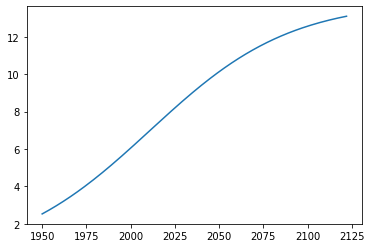

In [268]:
alpha = 25 / 1000
beta = -1.8 / 1000

quad = {}
p0 = un[t0]
quad[t0] = p0

for t in range(t0, 2122):
    growth = alpha * quad[t] + beta * quad[t]**2
    quad[t + 1] = quad[t] + growth
    
s = pd.Series(quad, name="Population")
s.plot()
print(s.tail())